In [24]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
train_dir = 'C:/Users/DELL/Downloads/New_folder/SEC_Five/dataset/train' 
test_dir  = 'C:/Users/DELL/Downloads/New_folder/SEC_Five/dataset/test'

In [26]:
# Set the input shape
input_shape = (128, 128, 3)
batch_size = 32

In [27]:
# Data augmentation
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [28]:
# Load training and test images
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=False
)

Found 12017 images belonging to 2 classes.


In [29]:
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 216 images belonging to 2 classes.


In [39]:
# Visualization of training images and class distribution
def visualize_samples(generator):
    sample_images, sample_labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[i])
        plt.title("Female" if sample_labels[i] == 0 else "Male")
        plt.axis("off")
    plt.show()

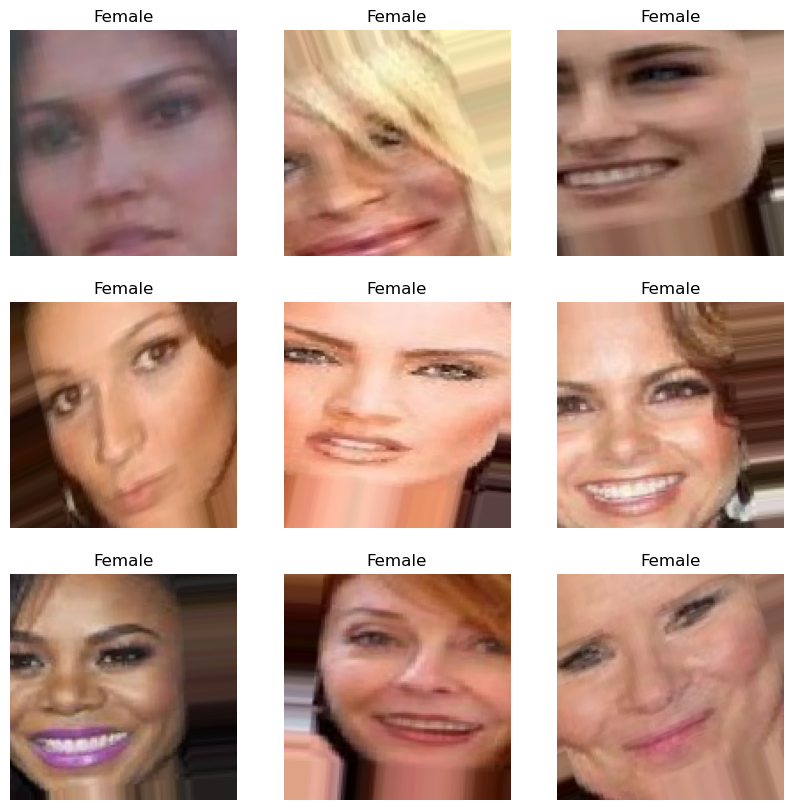

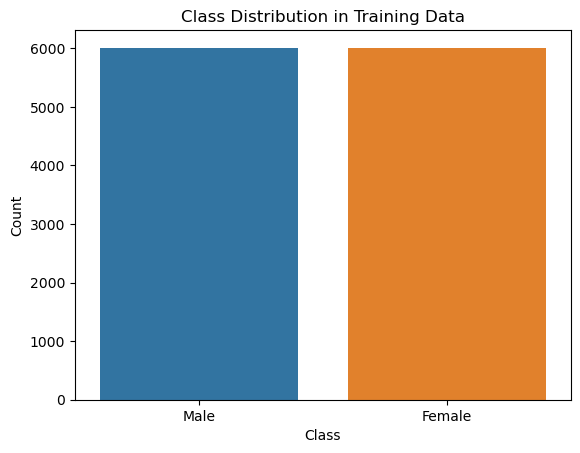

In [40]:
def visualize_class_distribution(generator):
    labels = generator.classes
    sns.countplot(x=labels)
    plt.title("Class Distribution in Training Data")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(ticks=[0, 1], labels=["Male", "Female"])
    plt.show()

visualize_samples(train_generator)
visualize_class_distribution(train_generator)

In [41]:
# Define CNN model for feature extraction
feature_extractor = Sequential([
    Conv2D(32, (3, 3), input_shape=input_shape),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5)
])

C:\Users\mf\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
# Extract features
train_features = feature_extractor.predict(train_generator)
train_features = train_features.reshape(train_features.shape[0], -1)
train_labels = train_generator.classes

test_features = feature_extractor.predict(test_generator)
test_features = test_features.reshape(test_features.shape[0], -1)
test_labels = test_generator.classes

376/376 ━━━━━━━━━━━━━━━━━━━━ 142s 377ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step


In [34]:
# Train XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)
xgb_classifier.fit(train_features, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [35]:
# Make predictions on the test set
test_predictions = xgb_classifier.predict(test_features)

# Calculate accuracy and display classification report
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(classification_report(test_labels, test_predictions, target_names=['Male', 'Female']))

Test Accuracy: 64.35%
              precision    recall  f1-score   support

        Male       0.64      0.67      0.65       108
      Female       0.65      0.62      0.64       108

    accuracy                           0.64       216
   macro avg       0.64      0.64      0.64       216
weighted avg       0.64      0.64      0.64       216



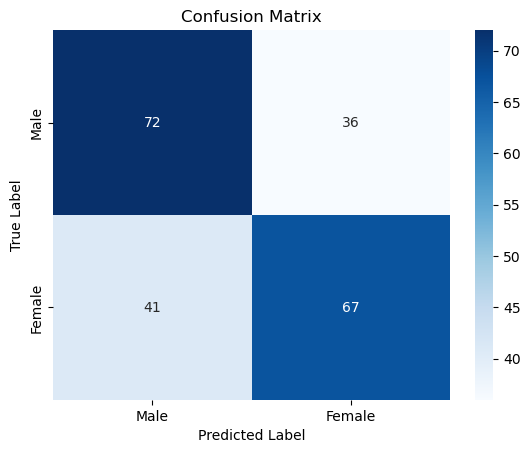

In [36]:
# Confusion matrix visualization
conf_matrix = confusion_matrix(test_labels, test_predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [37]:
# Save models
feature_extractor.save('cnn_feature_extractor_binary.h5')
joblib.dump(xgb_classifier, 'xgb_classifier_binary.pkl')

['xgb_classifier_binary.pkl']

In [ ]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import joblib
from keras.models import load_model
import xgboost as xgb

# Load the saved models
feature_extractor = load_model('cnn_feature_extractor_binary.h5')  # Your CNN model for feature extraction
xgb_classifier = joblib.load('xgb_classifier_binary.pkl')  # Your XGBoost model

# Function to classify a new image (male or female)
def classify_image(img_path):
    # Load and preprocess the new image
    img = load_img(img_path, target_size=(128, 128))  # Resize to match the CNN input
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to match the training preprocessing

    # Extract features using the CNN model
    features = feature_extractor.predict(img_array)  # Get the feature representation from CNN
    features = features.reshape(1, -1)  # Flatten the features for XGBoost

    # Classify the features with the XGBoost model
    prediction = xgb_classifier.predict(features)  # Predict using the XGBoost model
    
    # Return the classification result
    return "Female" if prediction[0] == 0 else "Male"

# Example usage
img_path = 'C:/Users/DELL/Downloads/New_folder/SEC_Five/dataset/test/female/113037.jpg.jpg'  # Provide the image path
result = classify_image(img_path)
print(f"The image is classified as: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
The image is classified as: Female
